# ДЗ №3 
## Обучение моделей глубокого обучения на PyTorch

In [1]:
!pip3 install torch torchvision numpy matplotlib

Ваша задача на этой неделе - повторить модель трёхслойного перцептрона из прошолго задания на **PyTorch**, разобрать лучшие практики обучения моделей глубокого обучения и провести серию экспериментов

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from typing import Tuple, List, Type, Dict, Any

Для того, чтобы эксперимент можно было повторить, хорошей практикой будет зафиксировать генератор случайных чисел. Также, рекоммендуется зафиксировать RNG в numpy и, если в качестве бэкенда используется cudnn - включить детерминированный режим.

Подробнее: https://pytorch.org/docs/stable/notes/randomness.html

In [3]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Модель

Основным способом организации кода на **Pytorch** является модуль. Простые модели могут быть реализованны из готовых модулей ( к примеру, `torch.nn.Sequential`, `torch.nn.Linear` и т.д. ), для более сложных архитектур часто приходтся реализовывать собственные блоки. Это достаточно легко сделать - достаточно написать класс, наследуемый от `torch.nn.Module` и реализующий метод `.forward`, который принимает и возвращает тензоры ( `torch.Tensor` )

Пример реализации кастомного модуля из официальной документации: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html3

#### Задание 1

Повторите реализацию трёхслойного перцептрона из предыдущего задания на **Pytorch**. Желательно также, чтобы реализация модели имела параметризуемую глубину ( количество слоёв ), количество параметров на каждом слое и функцию активации. Отсутствие такой возможности не снижает балл, но сильно поможет в освоении принципов построения нейросетей с применением библиотеки pytorch.

In [4]:
class Perceptron(torch.nn.Module):
    
    def __init__(self, 
                 input_resolution: Tuple[int, int] = (28, 28),
                 input_channels: int = 1, 
                 hidden_layer_features: List[int] = [256, 256, 256],
                 activation: Type[torch.nn.Module] = torch.nn.ReLU,
                 num_classes: int = 10,
                 n_hidden_neurons = 100):

        super(Perceptron, self).__init__()
        self.layer_1 = torch.nn.Linear(input_resolution[0] * input_resolution[1], n_hidden_neurons)
        self.act_1 = activation()
        self.layer_2 = torch.nn.Linear(n_hidden_neurons, num_classes)
        
    
    def forward(self, x):
        x = self.layer_1(x) # последовательно вызываем метод forward у наших модулей (как и в предыдущем дз)
        x = self.act_1(x)
        x = self.layer_2(x)
        return x 

Заметим, что тут мы не считаем softmax на выходе, чтобы получить вероятности принадлежности к классам. Это делаем осознано, так как в pytorch есть функция CrossEntropyLoss, которая включает в себя взятие softmax и затем кросс-энтропии, но она более вычислительно стабильна и работает быстрее (так написано в документации)

Следующий код позволяет посмотреть архитектуру получившейся модели и общее количество обучаемых параметров. Мы хотим, чтобы количество параметров в модели было порядка сотен тысяч. Если у вас получается больше или меньше, попробуйте изменить архитектуру модели.

In [77]:
model = Perceptron()
print(model)
print('Total number of trainable parameters', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

Perceptron(
  (layer_1): Linear(in_features=784, out_features=100, bias=True)
  (act_1): ReLU()
  (layer_2): Linear(in_features=100, out_features=10, bias=True)
)
Total number of trainable parameters 79510


получили модель, у которой примерно 80000 параметров (условие, что порядка 100 000 выполнено)

### Обучающая выборка

На практике, наиболее важным для успеха обучения любой модели машинного обучения является этап подготовки данных. Модели глубокого обучения не являются исключением. Большая, чистая, репрезентативная и релевантная поставленной задаче обучающая выборка часто важнее, чем архитектура самой модели. В предлагаемой задаче используется качественный и проверенный временем MNIST. Однако в практических задачах часто будет получаться так, что лучшим способом добиться улучшения качества модели будет сбор дополнительных данных и очистка исходных данных.

### Предобработка данных

Для улучшения сходимости алгоритма обучения и качества полученной модели данные могут быть предварительно обработаны:

1. Среднее каждой входной переменной близко к нулю
2. Переменные отмасштабированы таким образом, что их дисперсии примерно одинаковы ( из соображений вычислительной устойчивости, мы хотим, чтобы все величины по порядку величины были близки к еденице )
3. По возможности, входные переменные не должны быть скоррелированны. Важнось этого пункта в последние годы ставится под сомнение, но всё-же в некоторых случаях это может влиять на результат

Подробнее можно почитать здесь: http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf

### Аугментация (искусственное дополнение) обучающей выборки

В зависимости от задачи можно применять к признаковому описанию объектов обучающей выборки различные преобразования, которые позволят увеличить эффективный размер выборки без дополнительной разметки. К примеру, для задачи классификации кошек и собак можно зеркально отразить изображение вокруг вертикальной оси - при этом класс изображения не изменится, а само изображение останется по прежнему будет принадлежать исходному распределению. Есть много разных техник аугментации, и их применимость и эффективность сильно зависит от данных и задачи.

Подробнее можно почитать здесь: https://link.springer.com/content/pdf/10.1186/s40537-019-0197-0.pdf

### Задание 2

Обоснуйте, почему аугментация обучающей выборки позволяет добиться прироста качества модели, несмотря на то, что она не добавляет в неё дополнительную информацию.

# Ответ на 2ой вопрос
Рассмотрим картинку, на которой изображена кошка. Теперь сделаем некоторое преобразование с картинкой, например, вырежем некоторый кусок из этой картинки. Полученная картинка конечно останется кошкой (для нас визуально это вроде бы очевидно). Однако для нейронной сети это  будет совсем другой картинкой, потому что у нас будут задействованы совсем другие веса (например для свёрточной нейронной сети коэффициенты ядра будут меняться по другому и выделяются какие-то другие признаки). Также мы можем это изображение немножко растянуть или немножко сжать и у нас получится совсем другая картинка. То есть с нашей точки зрения картинка получится той же самой, практически, но для нейронной сети это будет совсем другая картинка, так как параметры будут меняться по-другому. 

### Задание 3

Какие осмысленные аугментации вы можете придумать для следующих наборов данных:

1. Набор изображений животных, размеченый на виды животных
2. Набор аудиозаписей голоса, размечеными на языки говорящего
3. Набор cо показаниями датчиков температуры, влажности и давления с одной из метеостанций, размеченый на признак наличия осадков

# Ответ на 3ий вопрос
1) Так как в этом случае датасет состоит из картинок, то можем применять стандартные методы аугментации к данным такого вида: то есть мы можем изменять цвет, насыщенность, мы можем изменять контраст. Мы можем добавлять различные шумы, такие как шум "соль и перец" который характерен для фото-матриц, мы можем добавлять гауссовский шум, мы можем применять различные графические эффекты и т.д.  

2) Можем ускорять или замедлять эту запись (то есть менять частоту), менять амплитуду (громкость) . Также логично её разбивать на несколько частей, если аудиодорожка большая. Можно также накладывать шумы (гауссовский шум) и так далее (не разу не работала с аудио и с моделями, которые решают подобные задачи, но это должно заставить модель учиться по-другому).

3) Аналогично можем сделать шумы на измерения показаний датчиков... В этом случае больше не знаю, что можно сделать с данными, чтобы изменить данные так, чтобы результат остался прежним, но для нейронной сети это были другие данные

### Задание 4

Напишите пайплайн для предобработки и аугументации данных. В `torchvision.transforms` есть готовые реализации большинства распространённых техник. Если вы хотите добавить что-то своё, вы можете воспользоваться `torchvision.transforms.Lambda`. При этом следует понимать, что если нужно оценить качество модели на оригинальных данных, пайплайн предварительной обработки данных валидационной выборки не должен включать аугментаций. Следует помнить, однако, что существует подход аугментации данных в момент применения модели (test-time augmentation), который позволяет повысить качество модели в режиме исполнения.

Одним из обязательных шагов в вашем пайплайне должна быть конвертация данных в тензоры Pytorch (`torch.Tensor`): `torchvision.transforms.ToTensor()`.

In [7]:
train_transforms = torchvision.transforms.Compose([
                                                 
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (1.0,)),
])

val_transforms = torchvision.transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (1.0,))
])

В трансформации данных переводим картинку в тензор, с помощью transforms.ToTensor() и нормализуем её


In [8]:
train_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                           train=True, 
                                           download=True,
                                           transform=train_transforms)

val_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                         train=False, 
                                         download=True, 
                                         transform=val_transforms)

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw




Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [9]:
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(1.0,))
           )


In [10]:
X_train = train_dataset.train_data # делаем данные для test и train для нашей нейронной сети
y_train = train_dataset.train_labels
X_test = val_dataset.test_data
y_test = val_dataset.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [11]:
X_train.shape

torch.Size([60000, 28, 28])

In [12]:
X_train = X_train.reshape([-1, 28 * 28]) # переводим трёхмерный тензор в двумерный
X_test = X_test.reshape([-1, 28 * 28])

In [13]:
train_dataset.train_data.shape


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])

In [14]:
X_train.shape

torch.Size([60000, 784])

Для начала просто преобразуем трёхмерный тензор, который поступает нам на вход, в двумерный (растянем картинку 28*28 в одну линию). Да, тем самымым мы потеряем информацию о том, какие пиксели находятся рядом, какие нет, но зато мы сможем применить наш многослойный Perceptron

Возможно это можно было сделать внутри класса torchvision.transforms.Compose, но я не разобралась как. Поэтому сделала это вне класса используя просто reshape, который подбирает первую зависимость автоматически, а вторую делает 28*28

Потом все равно использую dataloader, поэтому делаю reshape внутри каждой эпохи

Перед тем как запускать обучение всегда стоит посмотреть на данные после предобработки, и удостовериться, что они соответствуют ожидаемым

Не понимаю, как работает этот кусок кода...

In [ ]:
indices = np.random.randint(0, len(train_dataset), size=256)

fig, axes = plt.subplots(nrows=16, ncols=16, figsize=(32, 32))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        sample_index = indices[i*16+j]
        sample, label = train_dataset[sample_index]
        #print(sample.cpu().numpy().transpose(1, 2, 0))
        ax.imshow(sample.cpu().numpy().transpose(1, 2, 0))
        ax.set_title(label)

### Обучение модели

Теперь, когда мы реализовали модель и подготовили данные мы можем приступить к непосредственному обучению модели. Костяк функции обучения написан ниже, далее вы должны будете реализовать ключевые части этого алгоритма

In [78]:
def train_model(model: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                val_dataset: torch.utils.data.Dataset,
                loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim,
                optimizer_params: Dict = {},
                initial_lr = 0.01,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params: Dict = {},
                batch_size = 64,
                max_epochs = 100,
                early_stopping_patience = 20):
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, **optimizer_params)
    # optimizer = optimizer = optim.DiffGrad(
    #   model.parameters(),
    #   lr= 1e-3,
    #   betas=(0.9, 0.999),
    #   eps=1e-8,
    #   weight_decay=0,
    #   )

    lr_scheduler =torch.optim.lr_scheduler.StepLR(optimizer, lr_scheduler_params['step_size'], lr_scheduler_params['gamma'])
    #lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

    best_val_loss = None
    best_epoch = None
    loss_hist_train = []
    accuracy_hist_train = []

    loss_hist_val = []
    accuracy_hist_val = []
    for epoch in range(max_epochs):
        
        print(f'Epoch {epoch}')
        metric_train = train_single_epoch(model, optimizer, loss_function, train_loader) # тренировка отдельной эпохи
        #lr_scheduler.step()

        loss_hist_val.append(metric_train['loss']) # добавление в историю результатов тренировки
        accuracy_hist_val.append(metric_train['accuracy'])

        val_metrics = validate_single_epoch(model, loss_function, val_loader) # валидация

        loss_hist_train.append(val_metrics['loss'])
        accuracy_hist_train.append(val_metrics['accuracy'])
        print(f'Validation metrics: \n{val_metrics}')

        lr_scheduler.step(val_metrics['loss'])
        
        if best_val_loss is None or best_val_loss > val_metrics['loss']:
            print(f'Best model yet, saving')
            best_val_loss = val_metrics['loss']
            best_epoch = epoch
            torch.save(model, './best_model.pth')
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            break
            #return loss_hist_train, accuracy_hist_train, loss_hist_val, accuracy_hist_val
    return loss_hist_train, accuracy_hist_train, loss_hist_val, accuracy_hist_val

### Задание 5

Реализуйте функцию, производящую обучение сети на протяжении одной эпохи ( полного прохода по всей обучающей выборке ). На вход будет приходить модель, оптимизатор, функция потерь и объект типа `DataLoader`. При итерировании по `data_loader` вы будете получать пары вида ( данные, целевая_переменная )

In [17]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer, 
                       loss_function: torch.nn.Module, 
                       data_loader: torch.utils.data.DataLoader):
    loss_history = []
    accuracy_history = []
    for X, y in data_loader:
      X_batch = X.reshape([-1, 28 * 28])

      X_batch = X_batch.to(device) # переносим на видеопамять для вычисления (для скорости обучения делаю на colab)
      y = y.to(device)


      optimizer.zero_grad() # обнуляем градиент, так как он не обнуляется с предыдущей итерации

      pred = model.forward(X_batch) # получаю предсказание модели

      loss_value = loss_function(pred, y) # значение лосс функции на батче
      loss_history.append(loss_value)
      accuracy = (pred.argmax(dim=1) == y).float().mean() # точность это сколько из возможных угадала наша модель
      accuracy_history.append(accuracy)
      loss_value.backward() # производная по каждой из компонент нашей нейронной сети

      optimizer.step() # делаем шаг нашего оптимизатора
    return {'loss': float(sum(loss_history)/len(loss_history)), 'accuracy': float(sum(accuracy_history)/len(accuracy_history))}

### Задание 6

Реализуйте функцию производящую вычисление функции потерь на валидационной выборке.  На вход будет приходить модель, функция потерь и `DataLoader`. На выходе ожидается словарь с вида:
```
{
    'loss': <среднее значение функции потерь>,
    'accuracy': <среднее значение точности модели>
}
```

In [18]:
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module, 
                          data_loader: torch.utils.data.DataLoader):
    loss_history = []
    accuracy_history = []
    accuracy = 0
    for X, y in data_loader:
      X_test = X.reshape([-1, 28 * 28])
      pred_test = model.forward(X_test)  # получаем результат на валидации

      loss_val = loss_function(pred_test, y) # лосс функция на валидации на одном батче
      loss_history.append(loss_val) #  добавляем в массив значение лосс функции на батче
      accuracy = (pred_test.argmax(dim=1) == y).float().mean() # точность это сколько из возможных угадала наша модель
      accuracy_history.append(accuracy)
      
    res_dict = {'loss': float(sum(loss_history)/len(loss_history)), 'accuracy': float(sum(accuracy_history)/len(accuracy_history))}
    return res_dict







Если вы корректно реализовали все предыдущие шаги и ваша модель имеет достаточное количество обучаемых параметров, то в следующей ячейке должен пойти процесс обучения, и мы должны достичь итоговой точности (в смысле меры accuracy, доли верных ответов) выше 90%

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # если видеокарта доступно, будем переносить туда вычисления
model = model.to(device) # все параметры нейронной сети переносим на видеопамять, так как с ними вычисления происходят очень часто
# list(mnist_net.parameters()) # проверяем, что все веса и байесы переместились

In [ ]:
train_model(model, 
            train_dataset=train_dataset, 
            val_dataset=val_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.01)

Epoch 0
Validation metrics: 
{'loss': 0.16420666873455048, 'accuracy': 0.9523288011550903}
Best model yet, saving
Epoch 1
Validation metrics: 
{'loss': 0.17256665229797363, 'accuracy': 0.9499402642250061}
Epoch 2
Validation metrics: 
{'loss': 0.17492757737636566, 'accuracy': 0.9492436051368713}
Epoch 3
Validation metrics: 
{'loss': 0.15717710554599762, 'accuracy': 0.956409215927124}
Best model yet, saving
Epoch 4
Validation metrics: 
{'loss': 0.1613512635231018, 'accuracy': 0.9550158977508545}
Epoch 5
Validation metrics: 
{'loss': 0.1752701997756958, 'accuracy': 0.9487460255622864}
Epoch 6
Validation metrics: 
{'loss': 0.1733340322971344, 'accuracy': 0.9505374431610107}
Epoch 7
Validation metrics: 
{'loss': 0.16027899086475372, 'accuracy': 0.9541202187538147}
Epoch 8
Validation metrics: 
{'loss': 0.15008753538131714, 'accuracy': 0.9565087556838989}
Best model yet, saving
Epoch 9
Validation metrics: 
{'loss': 0.14529071748256683, 'accuracy': 0.9568073153495789}
Best model yet, saving
Ep

Выше представлено обучение модели, которая достигла точности 96.22


### Задание 7

Модифицируйте процесс обучения таким образом, чтобы достигнуть наилучшего качества на валидационной выборке. Модель должна оставаться N-слойным перцептроном с количеством обучаемых параметров <= 500000. Для обучения разрешается использовать только набор данных MNIST. Процесс обучения вы можете изменять по собственному усмотрению. К примеру, вы можете менять:

* Архитектуру модели в рамках наложенных ограничений на количество параметров и вид архитектуры (многослойный перцептрон)
* Функции активации в модели
* Используемый оптимизатор
* Расписание шага оптимизации
* Сэмплинг данных при обучении ( e.g. hard negative mining)

В результате мы ожидаем увидеть код экспериментов и любые инсайты, которые вы сможете получить в процессе

Потренируем модель ещё раз и посмотрим, как меняется значение loss функции и accuracy от эпохи

### !!!подписи в легенде на всех графиках должны быть наоборот (вместо val стоит train и вместо train стоит val)

когда анализировала не смотрела на легенду, так как понятно и без неё, где что, когда хотела отправлять, обнвружила эту ошибку... 

In [ ]:
loss_hist_train, accuracy_hist_train, loss_hist_val, accuracy_hist_val = train_model(model, 
            train_dataset=train_dataset, 
            val_dataset=val_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.01)

Epoch 0
Validation metrics: 
{'loss': 0.24809084832668304, 'accuracy': 0.9286425113677979}
Best model yet, saving
Epoch 1
Validation metrics: 
{'loss': 0.22148771584033966, 'accuracy': 0.9333200454711914}
Best model yet, saving
Epoch 2
Validation metrics: 
{'loss': 0.2041497379541397, 'accuracy': 0.9352110028266907}
Best model yet, saving
Epoch 3
Validation metrics: 
{'loss': 0.21240873634815216, 'accuracy': 0.933917224407196}
Epoch 4
Validation metrics: 
{'loss': 0.18734560906887054, 'accuracy': 0.9455612897872925}
Best model yet, saving
Epoch 5
Validation metrics: 
{'loss': 0.20193032920360565, 'accuracy': 0.9414808750152588}
Epoch 6
Validation metrics: 
{'loss': 0.19810079038143158, 'accuracy': 0.9435708522796631}
Epoch 7
Validation metrics: 
{'loss': 0.2094324380159378, 'accuracy': 0.9391918778419495}
Epoch 8
Validation metrics: 
{'loss': 0.20744284987449646, 'accuracy': 0.9381966590881348}
Epoch 9
Validation metrics: 
{'loss': 0.2039307802915573, 'accuracy': 0.9406847357749939}
Ep

Text(0, 0.5, '$loss$')

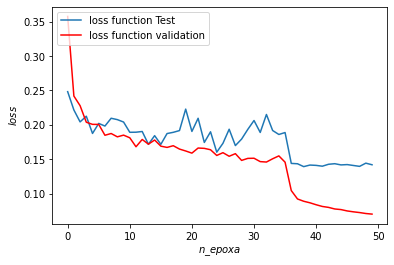

In [ ]:
plt.plot(loss_hist_train, label='loss function train') # график убывания loss функции от номера эпохи
plt.plot(loss_hist_val, label='loss function validation', c='r')
plt.legend(loc='upper left')
plt.xlabel('$n\_epoxa$')
plt.ylabel('$loss$')

допущена опечатка в место test в легенде графика конечно же должно быть подписано train

Text(0, 0.5, '$accuracy$')

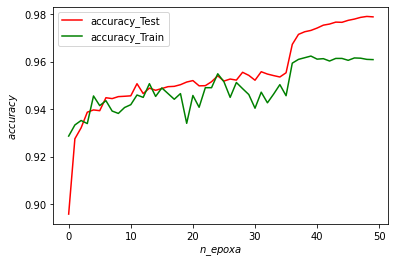

In [ ]:
plt.plot(accuracy_hist_val, c='r', label='accuracy_val')
plt.plot(accuracy_hist_train, c='g', label='accuracy_Train')
plt.legend(loc='upper left')
plt.xlabel('$n\_epoxa$')
plt.ylabel('$accuracy$')

### с функцией активации ReLU

Попробуем заменить функцию активации с Sigmod на ReLu и посмотреть, какой результат это даст (всё остальное: параметры обучения и модель, оставляем таким же)

In [24]:
loss_hist_train, accuracy_hist_train, loss_hist_val, accuracy_hist_val = train_model(model, 
            train_dataset=train_dataset, 
            val_dataset=val_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.01)

Epoch 0
Validation metrics: 
{'loss': 0.3259353041648865, 'accuracy': 0.9509354829788208}
Best model yet, saving
Epoch 1
Validation metrics: 
{'loss': 0.27265816926956177, 'accuracy': 0.9589968323707581}
Best model yet, saving
Epoch 2
Validation metrics: 
{'loss': 0.2526490390300751, 'accuracy': 0.9547173380851746}
Best model yet, saving
Epoch 3
Validation metrics: 
{'loss': 0.3133580982685089, 'accuracy': 0.9524283409118652}
Epoch 4
Validation metrics: 
{'loss': 0.31807002425193787, 'accuracy': 0.9446656107902527}
Epoch 5
Validation metrics: 
{'loss': 0.3830749988555908, 'accuracy': 0.9524283409118652}
Epoch 6
Validation metrics: 
{'loss': 0.3607003390789032, 'accuracy': 0.9425756335258484}
Epoch 7
Validation metrics: 
{'loss': 0.3290767967700958, 'accuracy': 0.9461584687232971}
Epoch 8
Validation metrics: 
{'loss': 0.34476056694984436, 'accuracy': 0.9409832954406738}
Epoch 9
Validation metrics: 
{'loss': 0.27251896262168884, 'accuracy': 0.9554139971733093}
Epoch 10
Validation metrics

Text(0, 0.5, '$loss$')

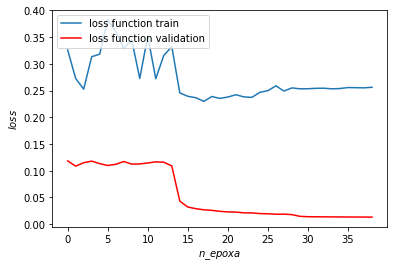

In [27]:
plt.plot(loss_hist_train, label='loss function train') # график убывания loss функции от номера эпохи
plt.plot(loss_hist_val, label='loss function validation', c='r')
plt.legend(loc='upper left')
plt.xlabel('$n\_epoxa$')
plt.ylabel('$loss$')

Text(0, 0.5, '$accuracy$')

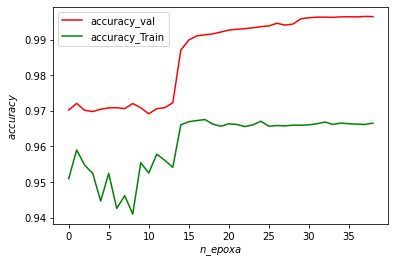

In [28]:
plt.plot(accuracy_hist_val, c='r', label='accuracy_val')
plt.plot(accuracy_hist_train, c='g', label='accuracy_Train')
plt.legend(loc='upper left')
plt.xlabel('$n\_epoxa$')
plt.ylabel('$accuracy$')

Полученная точность 96.65 совсем на немного лучше, чем с функцией активации sigmoid. Также по графикам видим, что тут мы сходимся за меньшее число эпох. То есть лосс перестаёт сильно скакать где-то на 15 эпохе, а с sigmoid на 40

### Изменение процесса обучения на модели с ReLU

Попробуем с помощью scheduler изменять шаг метода оптимизации - Adam каждые 5 эпох домножая на 0.95

In [79]:
loss_hist_train, accuracy_hist_train, loss_hist_val, accuracy_hist_val = train_model(model, 
            train_dataset=train_dataset, 
            val_dataset=val_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.01,
            lr_scheduler_params ={'step_size': 5, 'gamma': 0.95})

Epoch 0
Validation metrics: 
{'loss': 0.26532840728759766, 'accuracy': 0.9209793210029602}
Best model yet, saving
Epoch 1


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation metrics: 
{'loss': 0.17866624891757965, 'accuracy': 0.9475517272949219}
Best model yet, saving
Epoch 2
Validation metrics: 
{'loss': 0.20122089982032776, 'accuracy': 0.9429737329483032}
Epoch 3
Validation metrics: 
{'loss': 0.18655329942703247, 'accuracy': 0.9463574886322021}
Epoch 4
Validation metrics: 
{'loss': 0.18480248749256134, 'accuracy': 0.9494426846504211}
Epoch 5
Validation metrics: 
{'loss': 0.17479132115840912, 'accuracy': 0.949542224407196}
Best model yet, saving
Epoch 6
Validation metrics: 
{'loss': 0.18617790937423706, 'accuracy': 0.9526273608207703}
Epoch 7
Validation metrics: 
{'loss': 0.19902317225933075, 'accuracy': 0.9451631903648376}
Epoch 8
Validation metrics: 
{'loss': 0.23185314238071442, 'accuracy': 0.9387937784194946}
Epoch 9
Validation metrics: 
{'loss': 0.17662809789180756, 'accuracy': 0.9515326619148254}
Epoch 10
Validation metrics: 
{'loss': 0.19887042045593262, 'accuracy': 0.9508360028266907}
Epoch 11
Validation metrics: 
{'loss': 0.18537732958

Text(0, 0.5, '$loss$')

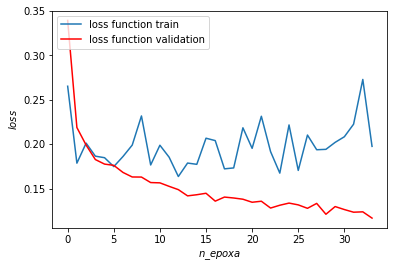

In [80]:
plt.plot(loss_hist_train, label='loss function train') # график убывания loss функции от номера эпохи
plt.plot(loss_hist_val, label='loss function validation', c='r')
plt.legend(loc='upper left')
plt.xlabel('$n\_epoxa$')
plt.ylabel('$loss$')

Text(0, 0.5, '$accuracy$')

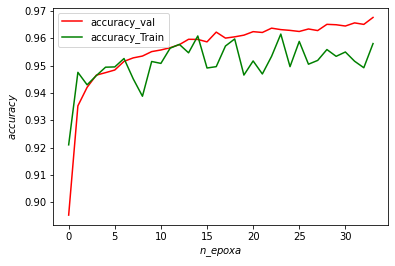

In [81]:
plt.plot(accuracy_hist_val, c='r', label='accuracy_val')
plt.plot(accuracy_hist_train, c='g', label='accuracy_Train')
plt.legend(loc='upper left')
plt.xlabel('$n\_epoxa$')
plt.ylabel('$accuracy$')

использование schedular не помогло достичь более лучшего результата... 

### Увелечение параметров до 100000

Попробуем немного изменить кол-во параметров модели, оставив её архитектуру такой же и посмотрим улучшиться как-то точность или нет

In [73]:
new_model = Perceptron(n_hidden_neurons=125) # вместо 100 выход после первого слоя будет 125
print(model)
print('Total number of trainable parameters', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

Perceptron(
  (layer_1): Linear(in_features=784, out_features=125, bias=True)
  (act_1): ReLU()
  (layer_2): Linear(in_features=125, out_features=10, bias=True)
)
Total number of trainable parameters 99385


Параметров сейчас как раз 100000 

In [62]:
loss_hist_train, accuracy_hist_train, loss_hist_val, accuracy_hist_val = train_model(new_model, 
            train_dataset=train_dataset, 
            val_dataset=val_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.01)

Epoch 0
Validation metrics: 
{'loss': 0.23586735129356384, 'accuracy': 0.9239649772644043}
Best model yet, saving
Epoch 1
Validation metrics: 
{'loss': 0.19628848135471344, 'accuracy': 0.9360071420669556}
Best model yet, saving
Epoch 2
Validation metrics: 
{'loss': 0.18648332357406616, 'accuracy': 0.9447651505470276}
Best model yet, saving
Epoch 3
Validation metrics: 
{'loss': 0.19025740027427673, 'accuracy': 0.9437699317932129}
Epoch 4
Validation metrics: 
{'loss': 0.1846940815448761, 'accuracy': 0.9454618096351624}
Best model yet, saving
Epoch 5
Validation metrics: 
{'loss': 0.18566566705703735, 'accuracy': 0.9491441249847412}
Epoch 6
Validation metrics: 
{'loss': 0.20152916014194489, 'accuracy': 0.9450637102127075}
Epoch 7
Validation metrics: 
{'loss': 0.1862269788980484, 'accuracy': 0.9508360028266907}
Epoch 8
Validation metrics: 
{'loss': 0.21830792725086212, 'accuracy': 0.9433718323707581}
Epoch 9
Validation metrics: 
{'loss': 0.16711243987083435, 'accuracy': 0.953125}
Best model

Text(0, 0.5, '$loss$')

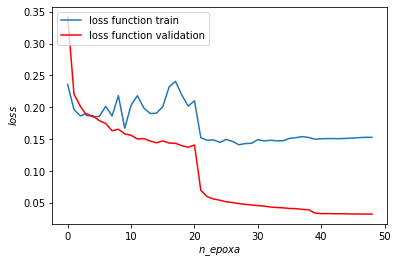

In [63]:
plt.plot(loss_hist_train, label='loss function train') # график убывания loss функции от номера эпохи
plt.plot(loss_hist_val, label='loss function validation', c='r')
plt.legend(loc='upper left')
plt.xlabel('$n\_epoxa$')
plt.ylabel('$loss$')

Text(0, 0.5, '$accuracy$')

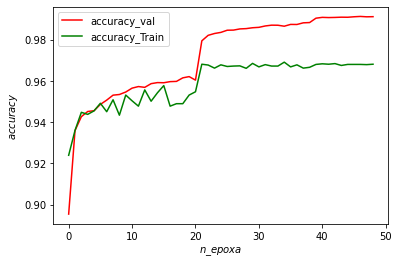

In [64]:
plt.plot(accuracy_hist_val, c='r', label='accuracy_val')
plt.plot(accuracy_hist_train, c='g', label='accuracy_Train')
plt.legend(loc='upper left')
plt.xlabel('$n\_epoxa$')
plt.ylabel('$accuracy$')

Точность модели 96.8 это на 0.15 выше, чем с меньшим кол-во параметров, хотя их мы добавили порядка 20000. Также можем заметить, что стало дольше учиться. Ну и последним экспериментом, попробуем поменять оптимизатор...

### Смена оптимизатора

Обучим модель с большим кол-вом параметров оптимизатором DiffGrad 

In [66]:
!pip install torch_optimizer

     |████████████████████████████████| 51kB 1.9MB/s 


In [67]:
import torch_optimizer as optim

In [74]:
loss_hist_train, accuracy_hist_train, loss_hist_val, accuracy_hist_val = train_model(new_model, 
            train_dataset=train_dataset, 
            val_dataset=val_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.01)

Epoch 0
Validation metrics: 
{'loss': 0.31794309616088867, 'accuracy': 0.9112260937690735}
Best model yet, saving
Epoch 1
Validation metrics: 
{'loss': 0.24723786115646362, 'accuracy': 0.9284434914588928}
Best model yet, saving
Epoch 2
Validation metrics: 
{'loss': 0.20217052102088928, 'accuracy': 0.9395899772644043}
Best model yet, saving
Epoch 3
Validation metrics: 
{'loss': 0.16215267777442932, 'accuracy': 0.9523288011550903}
Best model yet, saving
Epoch 4
Validation metrics: 
{'loss': 0.14648257195949554, 'accuracy': 0.956707775592804}
Best model yet, saving
Epoch 5
Validation metrics: 
{'loss': 0.12783682346343994, 'accuracy': 0.9619824886322021}
Best model yet, saving
Epoch 6
Validation metrics: 
{'loss': 0.11437034606933594, 'accuracy': 0.9661624431610107}
Best model yet, saving
Epoch 7
Validation metrics: 
{'loss': 0.10661973059177399, 'accuracy': 0.9675557613372803}
Best model yet, saving
Epoch 8
Validation metrics: 
{'loss': 0.10176507383584976, 'accuracy': 0.9698447585105896

Text(0, 0.5, '$loss$')

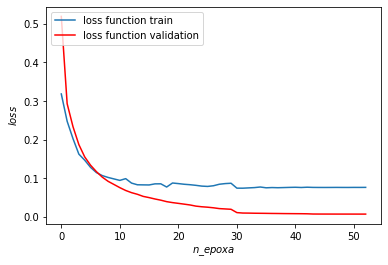

In [75]:
plt.plot(loss_hist_train, label='loss function train') # график убывания loss функции от номера эпохи
plt.plot(loss_hist_val, label='loss function validation', c='r')
plt.legend(loc='upper left')
plt.xlabel('$n\_epoxa$')
plt.ylabel('$loss$')

Text(0, 0.5, '$accuracy$')

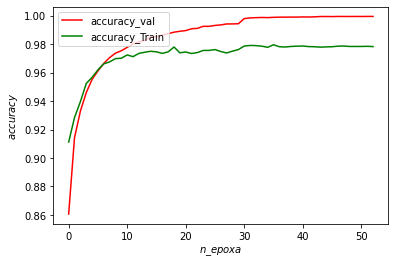

In [76]:
plt.plot(accuracy_hist_val, c='r', label='accuracy_val')
plt.plot(accuracy_hist_train, c='g', label='accuracy_Train')
plt.legend(loc='upper left')
plt.xlabel('$n\_epoxa$')
plt.ylabel('$accuracy$')

Лучший результат 97.9, то есть этот оптимизатор показал себя лучше, чем Adam да и график сходимости более плавный